# Interpretability

In [10]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

import sys
sys.path.append('../../../../')

import numpy as np
import pandas as pd

from molgraph.chemistry import MolecularGraphEncoder
from molgraph.chemistry import AtomicFeaturizer
from molgraph.chemistry import features

from molgraph.models import GradientActivationMapping
from molgraph.models import IntegratedSaliencyMapping

Build a `MolecularGraphEncoder`

In [2]:
atom_encoder = AtomicFeaturizer([
    features.Symbol({'C', 'N', 'O'}, oov_size=1),
    features.Hybridization({'SP', 'SP2', 'SP3'}, oov_size=1),
    features.HydrogenDonor(),
    features.HydrogenAcceptor(),
    features.Hetero()
])

bond_encoder = AtomicFeaturizer([
    features.BondType({'SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC'}),
    features.Rotatable()
])

mol_encoder = MolecularGraphEncoder(atom_encoder, bond_encoder, positional_encoding_dim=None)
mol_encoder

MolecularGraphEncoder(atom_encoder=AtomicFeaturizer(features=[Symbol(allowable_set=['[OOV:0]', 'C', 'N', 'O'], ordinal=False, oov_size=1), Hybridization(allowable_set=['[OOV:0]', 'SP', 'SP2', 'SP3'], ordinal=False, oov_size=1), HydrogenDonor(), HydrogenAcceptor(), Hetero()]), bond_encoder=AtomicFeaturizer(features=[BondType(allowable_set=['AROMATIC', 'DOUBLE', 'SINGLE', 'TRIPLE'], ordinal=False, oov_size=0), Rotatable()]), positional_encoding_dim=None, self_loops=False)

Obtain dataset

In [3]:
path = tf.keras.utils.get_file(
    fname='ESOL.csv',
    origin='http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/ESOL.csv',
)
df = pd.read_csv(path)
df.head(3)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)


Obtain SMILES `x`and associated labels `y`

In [4]:
x, y = df['smiles'].values, df['measured log solubility in mols per litre'].values

Obtain `GraphTensor` from `x`

In [5]:
x_data = mol_encoder(x)

print(x_data, end='\n\n')
print('node_feature shape:', x_data.node_feature.shape)
print('edge_dst shape:    ', x_data.edge_dst.shape)
print('edge_src shape:    ', x_data.edge_src.shape)
print('edge_feature shape:', x_data.edge_feature.shape)

GraphTensor(
  node_feature=<tf.RaggedTensor: shape=(1128, None, 11), dtype=float32>,
  edge_feature=<tf.RaggedTensor: shape=(1128, None, 5), dtype=float32>,
  edge_dst=<tf.RaggedTensor: shape=(1128, None), dtype=int32>,
  edge_src=<tf.RaggedTensor: shape=(1128, None), dtype=int32>)

node_feature shape: (1128, None, 11)
edge_dst shape:     (1128, None)
edge_src shape:     (1128, None)
edge_feature shape: (1128, None, 5)


### 1. Build Keras GNN **model** with GNN **layers**

In [6]:
from molgraph.layers import GCNConv, Readout

sequential_model = tf.keras.Sequential([
    tf.keras.layers.Input(type_spec=x_data.unspecific_spec),
    GCNConv(128, name='conv_1'),
    GCNConv(128, name='conv_2'),
    GCNConv(128, name='conv_3'),
    GCNConv(128, name='conv_4'),
    Readout(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1)
])

sequential_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (GCNConv)            (None, None, 128)         4864      
                                                                 
 conv_2 (GCNConv)            (None, None, 128)         33408     
                                                                 
 conv_3 (GCNConv)            (None, None, 128)         33408     
                                                                 
 conv_4 (GCNConv)            (None, None, 128)         33408     
                                                                 
 segment_pooling_readout (Se  (None, 128)              0         
 gmentPoolingReadout)                                            
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                        

### 2. Compile and fit GNN **model**

In [7]:
sequential_model.compile('adam', 'mse', ['mae'])
sequential_model.fit(x_data, y, epochs=50, verbose=2)

Epoch 1/50
36/36 - 3s - loss: 4.0684 - mae: 1.5942 - 3s/epoch - 86ms/step
Epoch 2/50
36/36 - 0s - loss: 3.1554 - mae: 1.4086 - 214ms/epoch - 6ms/step
Epoch 3/50
36/36 - 0s - loss: 2.5349 - mae: 1.2603 - 212ms/epoch - 6ms/step
Epoch 4/50
36/36 - 0s - loss: 2.4617 - mae: 1.2195 - 213ms/epoch - 6ms/step
Epoch 5/50
36/36 - 0s - loss: 2.2271 - mae: 1.1630 - 213ms/epoch - 6ms/step
Epoch 6/50
36/36 - 0s - loss: 2.2356 - mae: 1.1724 - 212ms/epoch - 6ms/step
Epoch 7/50
36/36 - 0s - loss: 2.4721 - mae: 1.2369 - 216ms/epoch - 6ms/step
Epoch 8/50
36/36 - 0s - loss: 2.1311 - mae: 1.1480 - 213ms/epoch - 6ms/step
Epoch 9/50
36/36 - 0s - loss: 2.0199 - mae: 1.0934 - 212ms/epoch - 6ms/step
Epoch 10/50
36/36 - 0s - loss: 2.0254 - mae: 1.1093 - 214ms/epoch - 6ms/step
Epoch 11/50
36/36 - 0s - loss: 1.8265 - mae: 1.0234 - 219ms/epoch - 6ms/step
Epoch 12/50
36/36 - 0s - loss: 1.8160 - mae: 1.0430 - 215ms/epoch - 6ms/step
Epoch 13/50
36/36 - 0s - loss: 1.8362 - mae: 1.0293 - 214ms/epoch - 6ms/step
Epoch 14/5

### 3. Pass GNN **model** to **GradientActivationMapping** and **predict**

In [8]:
gam_model = GradientActivationMapping(
    sequential_model, 
    ['conv_1', 'conv_2', 'conv_3', 'conv_4'], 
    output_activation=None,
    discard_negative_values=False,
)    

gam = gam_model.predict(x_data, verbose=1)
print(gam[0])

36/36 [==============================] - 2s 5ms/step
tf.Tensor(
[ 0.00032118  0.00193872 -0.00045658 -0.00190615  0.00139575 -0.00158606
  0.00069461 -0.00064468 -0.00191414  0.00135925 -0.00202261 -0.00109826
 -0.00100078 -0.00215375 -0.0013663  -0.00087172 -0.00050907 -0.00049854
 -0.00050907 -0.00087172  0.00037442 -0.00034017  0.00046559 -0.00035606
  0.00053896 -0.00031878  0.00037691 -0.00034033  0.00046496 -0.00035606
  0.00052919 -0.00032243], shape=(32,), dtype=float32)


### 4. Visualize **maps** on molecule

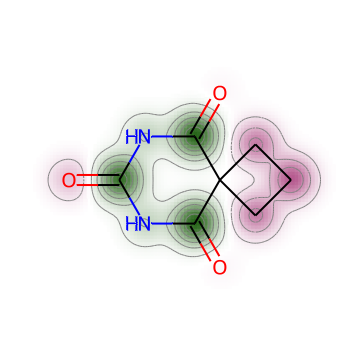

In [9]:
from molgraph.chemistry import vis

vis.visualize_maps(molecule=x[42], maps=gam[42])